# Training a Variational Autoencoder (VAE) on the MNIST Dataset 

This notebook explores the creation and training of a Variational Autoencoder (VAE) using PyTorch to reconstruct and generate handwritten digits from the MNIST dataset. The VAE extends the traditional autoencoder by introducing a probabilistic framework, where the encoder maps input images to a distribution in a latent space rather than fixed points. This probabilistic nature allows the VAE to generate diverse samples from the learned latent space, setting it apart from standard deterministic autoencoders. This implementation serves as a foundation for further architectural enhancements to improve reconstruction quality and generation fidelity.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 57668353.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1541303.85it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13975365.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2772195.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Loss: 167.1533
Epoch 2, Loss: 122.3964
Epoch 3, Loss: 114.8168
Epoch 4, Loss: 111.6707
Epoch 5, Loss: 109.8083
Epoch 6, Loss: 108.6426
Epoch 7, Loss: 107.7618
Epoch 8, Loss: 107.0739
Epoch 9, Loss: 106.5328
Epoch 10, Loss: 106.1137
Epoch 11, Loss: 105.7394
Epoch 12, Loss: 105.4328
Epoch 13, Loss: 105.1973
Epoch 14, Loss: 104.8548
Epoch 15, Loss: 104.6854
Epoch 16, Loss: 104.4832
Epoch 17, Loss: 104.2857
Epoch 18, Loss: 104.0963
Epoch 19, Loss: 103.9305
Epoch 20, Loss: 103.8379


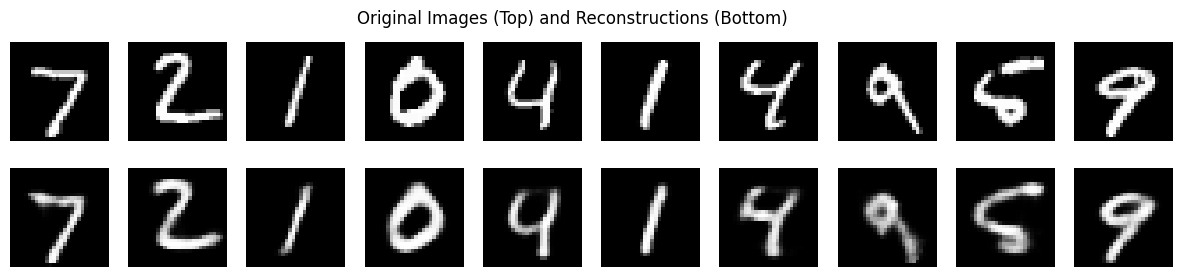

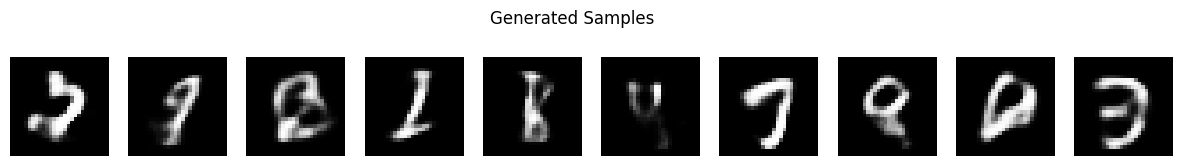

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define batch size for training and testing
batch_size = 128

# Define transformation: convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Load MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

class VAE(nn.Module):
    """
    A simple Variational Autoencoder (VAE) with fully connected layers.
    """
    def __init__(self, hidden_dim=400, latent_dim=20):
        """
        Initialize the VAE model with encoder and decoder layers.
        
        Args:
            hidden_dim (int): Number of neurons in the hidden layers.
            latent_dim (int): Dimension of the latent space.
        """
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(784, hidden_dim)            # Input layer to hidden layer
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)  # Hidden layer to mean of latent distribution
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)  # Hidden layer to log-variance of latent distribution
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)     # Latent space to hidden layer
        self.fc4 = nn.Linear(hidden_dim, 784)            # Hidden layer to output layer
        
    def encode(self, x):
        """
        Encode input images into mean and log-variance of latent distribution.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, 784).
        
        Returns:
            Tuple[Tensor, Tensor]: Mean and log-variance tensors.
        """
        h = torch.relu(self.fc1(x))  # Apply ReLU activation
        return self.fc2_mu(h), self.fc2_logvar(h)  # Return mean and log-variance
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        
        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.
        
        Returns:
            Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)    # Calculate standard deviation
        eps = torch.randn_like(std)      # Sample epsilon from standard normal
        return mu + eps * std            # Return sampled latent vector
    
    def decode(self, z):
        """
        Decode latent vectors back to image space.
        
        Args:
            z (Tensor): Latent vector tensor of shape (batch_size, latent_dim).
        
        Returns:
            Tensor: Reconstructed image tensor of shape (batch_size, 784).
        """
        h = torch.relu(self.fc3(z))          # Apply ReLU activation
        return torch.sigmoid(self.fc4(h))    # Apply Sigmoid to get output between 0 and 1
    
    def forward(self, x):
        """
        Forward pass through the VAE.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, 784).
        
        Returns:
            Tuple[Tensor, Tensor, Tensor]: Reconstructed tensor, mean, and log-variance.
        """
        mu, logvar = self.encode(x)         # Encode input to latent distribution parameters
        z = self.reparameterize(mu, logvar) # Sample from latent distribution
        x_recon = self.decode(z)            # Decode sampled latent vector
        return x_recon, mu, logvar          # Return reconstruction and distribution parameters

# Instantiate the VAE model and move it to the appropriate device
model = VAE().to(device)

# Define the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    """
    Compute the VAE loss function as the sum of reconstruction loss and KL divergence.
    
    Args:
        recon_x (Tensor): Reconstructed tensor from the decoder.
        x (Tensor): Original input tensor.
        mu (Tensor): Mean from the encoder's latent space.
        logvar (Tensor): Log-variance from the encoder's latent space.
    
    Returns:
        Tensor: Total loss.
    """
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )  # Reconstruction loss
    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )  # KL divergence
    return BCE + KLD  # Total loss

# Set the number of training epochs
epochs = 20

# Set the model to training mode
model.train()

# Training loop
for epoch in range(epochs):
    train_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)   # Flatten the input and move to device
        optimizer.zero_grad()                  # Reset gradients
        recon_batch, mu, logvar = model(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, logvar)  # Compute loss
        loss.backward()                        # Backpropagation
        train_loss += loss.item()              # Accumulate loss
        optimizer.step()                       # Update model parameters
    # Print average loss per epoch
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

# Save the trained model parameters
torch.save(model.state_dict(), 'vae_mnist.pt')

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Get a batch of test data
    data, _ = next(iter(test_loader))
    data = data.view(-1, 784).to(device)   # Flatten the input and move to device
    recon, _, _ = model(data)              # Reconstruct the input
    z = torch.randn(batch_size, 20).to(device)  # Sample random latent vectors
    samples = model.decode(z)               # Generate new samples from latent vectors

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0, i].imshow(data[i].cpu().view(28, 28), cmap='gray')
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original Images (Top) and Reconstructions (Bottom)')
plt.show()

# Plot generated samples
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(samples[i].cpu().view(28, 28), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Generated Samples')
plt.show()


# Analysis of Results

Upon visualizing the outputs of the trained VAE, the following observations can be made:

Original vs. Reconstructed Images:

First Row: Displays original handwritten digits from the MNIST test dataset.
Second Row: Shows the corresponding reconstructions produced by the VAE.
Observation: While the VAE successfully captures the general structure of the digits, some reconstructions exhibit blurriness or lack fine details, indicating room for improvement in the model's capacity or architecture.
Generated Samples:

Third Visualization: Presents new digit images generated by decoding randomly sampled latent vectors.
Observation: The generated samples resemble handwritten digits but may lack consistency and clarity compared to the original dataset. This suggests that the latent space might benefit from further refinement to enhance the quality of generated images.

# Transition to an Enhanced Architecture for a More Performant VAE

To improve the initial VAE, we can implement the following enhancements:

**Convolutional Layers:**

Convolutional layers are highly effective for processing grid-structured data like images. They can capture local patterns and spatial hierarchies, leading to better feature extraction and reconstruction quality.

**Residual Blocks:**

Residual blocks facilitate the training of deeper networks by allowing gradients to flow more easily through the network. They help mitigate issues like vanishing gradients and enable the model to learn more complex representations.

**Increased Latent Dimension:**

A higher latent dimension provides the model with greater capacity to capture the diversity and nuances present in the data, leading to more detailed and varied reconstructions and generations.

**Batch Normalization:**

Batch normalization stabilizes and accelerates training by normalizing layer inputs, which helps in maintaining consistent distributions of activations throughout the network.

**Weight Decay (L2 Regularization):**

Weight decay penalizes large weights, helping to prevent overfitting and improve the model's generalization performance on unseen data.

**Extended Training Epochs:**

Increasing the number of training epochs allows the model more time to converge to a better minimum, resulting in lower loss values and improved reconstruction quality.

Epoch 1, Loss: 149.6105
Epoch 2, Loss: 108.2590
Epoch 3, Loss: 104.7498
Epoch 4, Loss: 102.9164
Epoch 5, Loss: 101.8190
Epoch 6, Loss: 100.8035
Epoch 7, Loss: 100.2182
Epoch 8, Loss: 99.5890
Epoch 9, Loss: 99.2003
Epoch 10, Loss: 98.6821
Epoch 11, Loss: 98.2770
Epoch 12, Loss: 97.8999
Epoch 13, Loss: 97.6050
Epoch 14, Loss: 97.2080
Epoch 15, Loss: 96.9121
Epoch 16, Loss: 96.6585
Epoch 17, Loss: 96.3927
Epoch 18, Loss: 96.0746
Epoch 19, Loss: 95.8685
Epoch 20, Loss: 95.6956
Epoch 21, Loss: 95.4215
Epoch 22, Loss: 95.1909
Epoch 23, Loss: 94.9907
Epoch 24, Loss: 94.8781
Epoch 25, Loss: 94.5530
Epoch 26, Loss: 94.5025
Epoch 27, Loss: 94.3142
Epoch 28, Loss: 94.0957
Epoch 29, Loss: 93.9535
Epoch 30, Loss: 93.8345


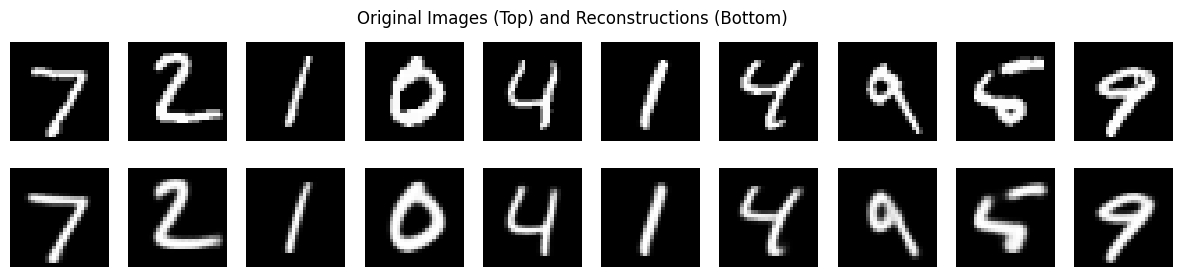

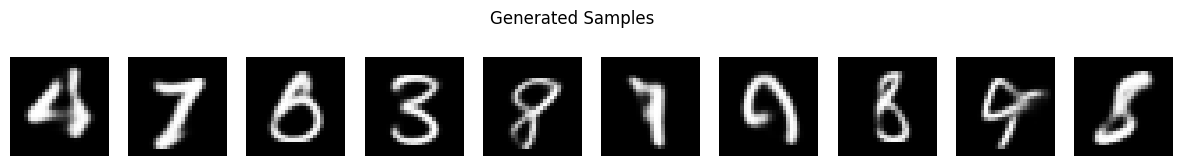

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define batch size for training and testing
batch_size = 128

# Define transformation: convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST training dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Load MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        # First convolutional layer followed by batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer followed by batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Adjust input dimensions if they differ using a 1x1 convolution
        if in_channels != out_channels:
            self.adjust = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.adjust = nn.Identity()
        
    def forward(self, x):
        identity = self.adjust(x)            # Direct path for the residual connection
        out = self.conv1(x)                  # First convolution
        out = self.bn1(out)                  # Batch normalization
        out = self.relu(out)                 # ReLU activation
        out = self.conv2(out)                # Second convolution
        out = self.bn2(out)                  # Batch normalization
        out += identity                       # Adding the residual connection
        out = self.relu(out)                 # Final ReLU activation
        return out

class EnhancedConvVAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(EnhancedConvVAE, self).__init__()
        # Encoder with convolutional layers and residual blocks
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Reduces image size from 28x28 to 14x14
            nn.BatchNorm2d(32),                                     # Batch normalization
            nn.ReLU(),                                              # ReLU activation
            ResidualBlock(32, 64),                                  # Residual block increasing channels to 64
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Reduces image size to 7x7
            nn.BatchNorm2d(128),                                    # Batch normalization
            nn.ReLU(),                                              # ReLU activation
            ResidualBlock(128, 256),                                # Residual block increasing channels to 256
            nn.Flatten()                                            # Flattening for fully connected layers
        )
        self.fc_mu = nn.Linear(256 * 7 * 7, latent_dim)            # Fully connected layer for mean
        self.fc_logvar = nn.Linear(256 * 7 * 7, latent_dim)        # Fully connected layer for log-variance
        
        # Decoder with transposed convolutional layers and residual blocks
        self.fc_decode = nn.Linear(latent_dim, 256 * 7 * 7)        # Fully connected layer to decode latent space
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsamples to 14x14
            nn.BatchNorm2d(128),                                             # Batch normalization
            nn.ReLU(),                                                      # ReLU activation
            ResidualBlock(128, 64),                                          # Residual block reducing channels to 64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Upsamples to 28x28
            nn.BatchNorm2d(32),                                              # Batch normalization
            nn.ReLU(),                                                      # ReLU activation
            ResidualBlock(32, 32),                                           # Residual block maintaining channels
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),     # Final convolution to get output image
            nn.Sigmoid()                                                    # Sigmoid activation to output values between 0 and 1
        )
        
    def encode(self, x):
        h = self.encoder(x)                   # Passing input through the encoder
        mu = self.fc_mu(h)                    # Obtaining the mean of the latent distribution
        logvar = self.fc_logvar(h)            # Obtaining the log-variance of the latent distribution
        return mu, logvar                     # Returning mean and log-variance
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)         # Calculating standard deviation
        eps = torch.randn_like(std)           # Sampling epsilon from a standard normal distribution
        return mu + eps * std                 # Reparameterization trick to obtain latent vector
    
    def decode(self, z):
        h = self.fc_decode(z)                 # Decoding latent vector through the fully connected layer
        h = h.view(-1, 256, 7, 7)             # Reshaping to match convolutional layer expectations
        x_recon = self.decoder(h)             # Passing through the decoder to reconstruct the image
        return x_recon                        # Returning the reconstructed image
    
    def forward(self, x):
        mu, logvar = self.encode(x)           # Encoding the input to get mean and log-variance
        z = self.reparameterize(mu, logvar)   # Sampling the latent vector
        x_recon = self.decode(z)              # Decoding to reconstruct the image
        return x_recon, mu, logvar            # Returning the reconstruction and distribution parameters

# Instantiate the EnhancedConvVAE model and move it to the appropriate device
model = EnhancedConvVAE(latent_dim=100).to(device)

# Define the Adam optimizer with a learning rate of 0.001 and weight decay of 1e-5
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def loss_function(recon_x, x, mu, logvar):
    """
    Compute the VAE loss function as the sum of reconstruction loss and KL divergence.
    
    Args:
        recon_x (Tensor): Reconstructed tensor from the decoder.
        x (Tensor): Original input tensor.
        mu (Tensor): Mean from the encoder's latent space.
        logvar (Tensor): Log-variance from the encoder's latent space.
    
    Returns:
        Tensor: Total loss.
    """
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )  # Reconstruction loss (Binary Cross-Entropy)
    KLD = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )  # KL divergence
    return BCE + KLD  # Total loss

# Set the number of training epochs
epochs = 30

# Set the model to training mode
model.train()
for epoch in range(epochs):
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)          # Moving data to the device (GPU/CPU)
        optimizer.zero_grad()           # Resetting gradients
        recon_batch, mu, logvar = model(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, logvar)  # Computing loss
        loss.backward()                 # Backpropagation
        train_loss += loss.item()       # Accumulating loss
        optimizer.step()                # Updating model parameters
    # Printing the average loss per epoch
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

# Save the trained model parameters
torch.save(model.state_dict(), 'enhanced_residual_conv_vae_mnist.pt')

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Retrieving a batch of test data
    data, _ = next(iter(test_loader))
    data = data.to(device)               # Moving data to the device
    recon, _, _ = model(data)            # Reconstructing the input
    z = torch.randn(batch_size, 100).to(device)  # Sampling random latent vectors
    samples = model.decode(z)             # Generating new samples from latent vectors

# Plotting original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    # Reconstructed images
    axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original Images (Top) and Reconstructions (Bottom)')
plt.show()

# Plotting generated samples
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(samples[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Generated Samples')
plt.show()


# Analysis of Results

After training the enhanced VAE, the loss consistently decreases from 146.23 in the first epoch to 94.00 by the 30th epoch, indicating improved performance compared to the initial model. The reconstructions are more accurate, and the generated samples align better with the MNIST digits. However, both reconstructed and generated images exhibit noticeable blurriness.

This blurriness is a common limitation of VAEs due to their probabilistic nature. The decoder generates outputs by sampling from a latent distribution, which introduces variability and often smoothens the fine details of the images. This results in outputs that lack sharpness, as the model prioritizes producing general patterns over exact pixel-level details.